#### Thinkful Data Science program - Unsupervised Learning Capstone
#### Stu Alden
#### May 3, 2021


### Background:
* I have a very large music library, built from ripping files off of my CDs and converting the files to MP3 format to save on storage space.  
* The files are organized at the top level by "genre," which has proved a more challenging concept that I would have originally expected - for example, many artists straddle multiple genres. 
* Genre seems to be a function not only of instrumentation, but tempo, rhythm, volume and other factors.

* Unfortunately, genre by itself is not a good guide for choosing a playlist (a sequence of musical tracks to play).  To improve playlist creation (possibly even automate it), I thought it would be valuable to assign a "mood" to each track.  

* Logical categories of "mood" might include, for example, music for waking up, music for going to bed, music for a  lively party, music for a quiet dinner party, etc.  

* Of course, there can be significant overlap in these moods, and a particular track might be approriately assigned 2 or more moods.

* To make this capstone a "pure" unsupervised learning exercise, I chose **not** to define moods, other than enforce the general notion that the number of moods for a useful classification system would certainly be less than, say, 10, and great than, say, 3 or 4.

* Due to time constraints and performance issues, I chose a small subset of my music library, specifically the 13 core US albums of the English band The Beatles.  

* The Beatles' music would generally be assigned the genre "rock," but of course there is a wide variety of moods in their music, covering the full range from lullabyes to hard-rocking tunes with all different kinds of instrumentation.


In addition to the material we learned in the Thinkful course so far, I picked up a number of ideas from the following  project:

"Music Genre Classification Using Supervised and Unsupervised Learning" by William Easterby, May 13, 2020

https://medium.com/@weasterby/music-genre-classification-using-supervised-and-unsupervised-learning-cf1f0837d725

This article was particular helpful with introducing me to the capabilities of the `librosa` audio analysis library and suggesting code to help with visualizations.  It also introduced me to some other measures of clustering success (besides silhouette coefficients).



* I intend to take this project further until I am able to automate a "mood-assignment" algorithm and make use of it in developing playlists from my library.  
* Such an algorithm would be useful to anyone to listens to a wide variety of music and who would like an easy way to identify music appropriate to various situations.

In [62]:
import os, warnings, csv
import IPython.display as ipd

import librosa, librosa.display

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas

from scipy.stats import kurtosis, skew

from sklearn.preprocessing import StandardScaler, minmax_scale 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn import metrics

import umap


In [54]:
# If desired, listen to the track
audio_file = "17_Her Majesty.mp3"
#audio_file = "07_Maggie Mae.mp3"
ipd.Audio(audio_file)

In [56]:
# Read the file into a librosa array called sound, check on some stats

with warnings.catch_warnings():                  # Avoid warning about reading MP3s
    warnings.simplefilter("ignore")
    sound, sr = librosa.load(audio_file)

track_minutes = (len(sound) / sr ) // 60
track_seconds = 60 * ((len(sound) / sr) / 60 - track_minutes)

tempo, beat_frames = librosa.beat.beat_track(y=sound, sr=sr)

print('Sampling Rate:     {:,.0f} times per second'.format(sr))
print('Number of Samples: {:,.0f}'.format(len(sound)))
print('Track length:      {:.0f} minutes {:.0f} seconds'.format(track_minutes, track_seconds))
print('Estimated tempo:   {:.0f} beats per minute'.format(tempo))

Sampling Rate:     22,050 times per second
Number of Samples: 573,006
Track length:      0 minutes 26 seconds
Estimated tempo:   99 beats per minute


### Features:

* Let's examine some of the various features that `librosa` can extract from a music waveform.

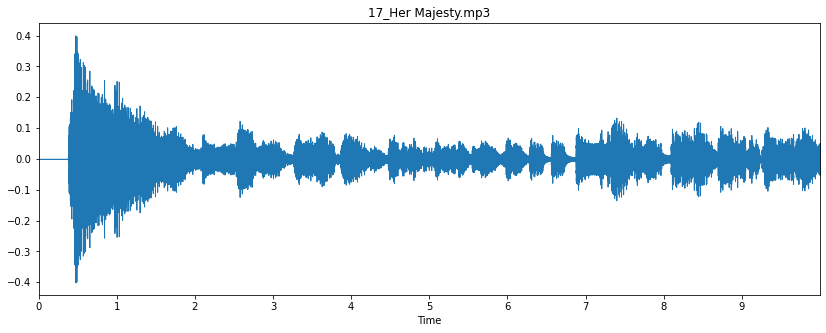

In [4]:
# Just display the waveform itself (first 10 seconds)

plt.figure(figsize=(14, 5))
plt.title(audio_file)
librosa.display.waveplot(sound[0:(10*sr)], sr=sr)

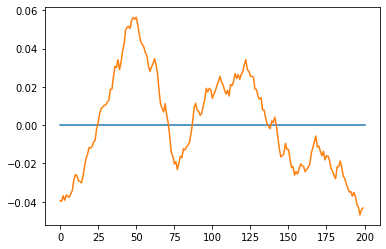

In [6]:
# Illustrate the zero crossing rate
plt.plot([0,200],[0,0])
start_point = len(sound) // 2
plt.plot(sound[start_point:start_point + 200]) # Grab a 200-sample chunk from the middle

In [7]:
# Examine zero_crossings per second
zero_crossings = librosa.zero_crossings(sound, pad=False)  # fills array with true/false if crossing/not crossing
zcps = sum(zero_crossings) / (len(sound) / sr)
print("Zero Crossings per second:  {:,.0f}".format(zcps))

Zero Crossings per second:  1,227


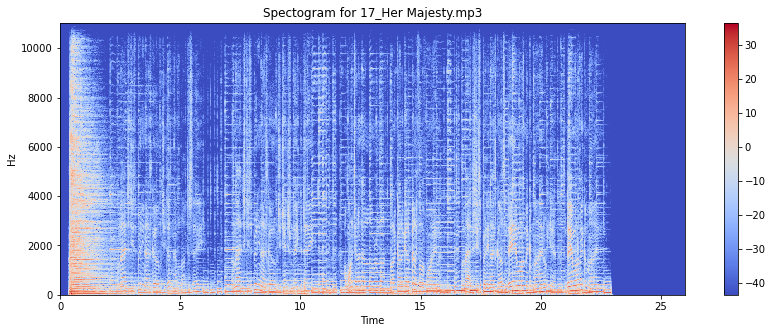

In [5]:
# Look at a spectrogram of the waveform

X = librosa.stft(sound)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.title('Spectrogram for '+audio_file)
plt.colorbar()

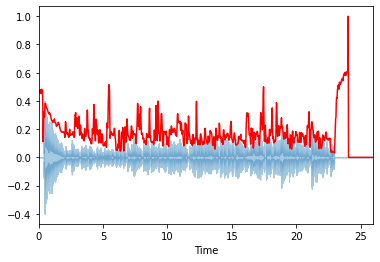

In [57]:
# Determine the spectral centroid - weighted mean of frequencies in signal, with their magnitudes as the weights
spectral_centroids = librosa.feature.spectral_centroid(sound, sr=sr)[0]
# Time variable t for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalize the spectral centroid for visualisation
def normalize(x, axis=0):
     return minmax_scale(x, axis=axis)
#Plot the Spectral Centroid (red) next to the waveform (blue)
librosa.display.waveplot(sound, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

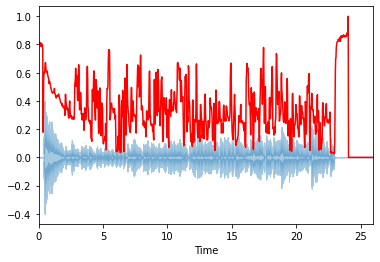

In [13]:
# Graph the spectral rolloff frequency - frequency above or below which a filter 
# blocks waveform harmonics.

spectral_rolloff = librosa.feature.spectral_rolloff(sound, sr=sr)[0]
librosa.display.waveplot(sound, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 1749)


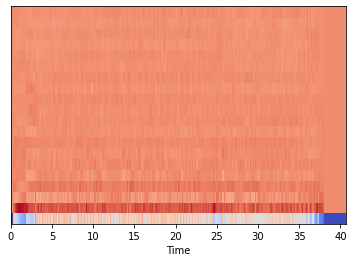

In [62]:
# Compute 20 Mel Frequency Cepstral Coefficients (MFCCs)

mfccs = librosa.feature.mfcc(sound, sr=sr)
print(mfccs.shape)  # same second dimension as spectral centroid - must mean something!!
# print(mfccs)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

(7, 1749)


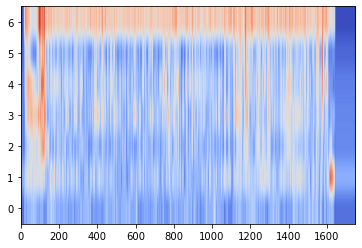

In [29]:
# Spectral contrast - difference between peak and valley in each frequency subband.
spectral_contrast = librosa.feature.spectral_contrast(sound, sr=sr)
#print(spectral_contrast.shape)
plt.imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')

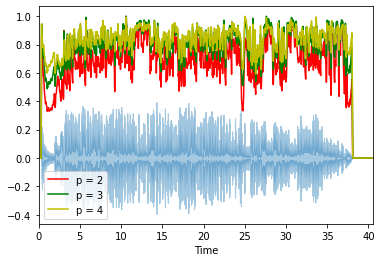

In [30]:
# Look at p-order spectral bandwidth, with p = 2, 3, and 4

spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(sound+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(sound+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(sound+0.01, sr=sr, p=4)[0]
librosa.display.waveplot(sound, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

(1, 1749)


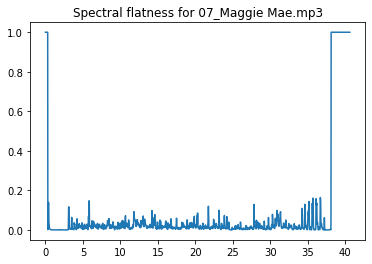

In [31]:
# Spectral flatness - ratio of the geometric mean to the arithmetic mean of the power spectrum
spectral_flatness = librosa.feature.spectral_flatness(sound)
print(spectral_flatness.shape)

# graph it
sf_length = spectral_flatness.shape[1]
plt.plot(t, spectral_flatness.reshape(sf_length,1))
plt.title('Spectral flatness for '+audio_file)
plt.show()


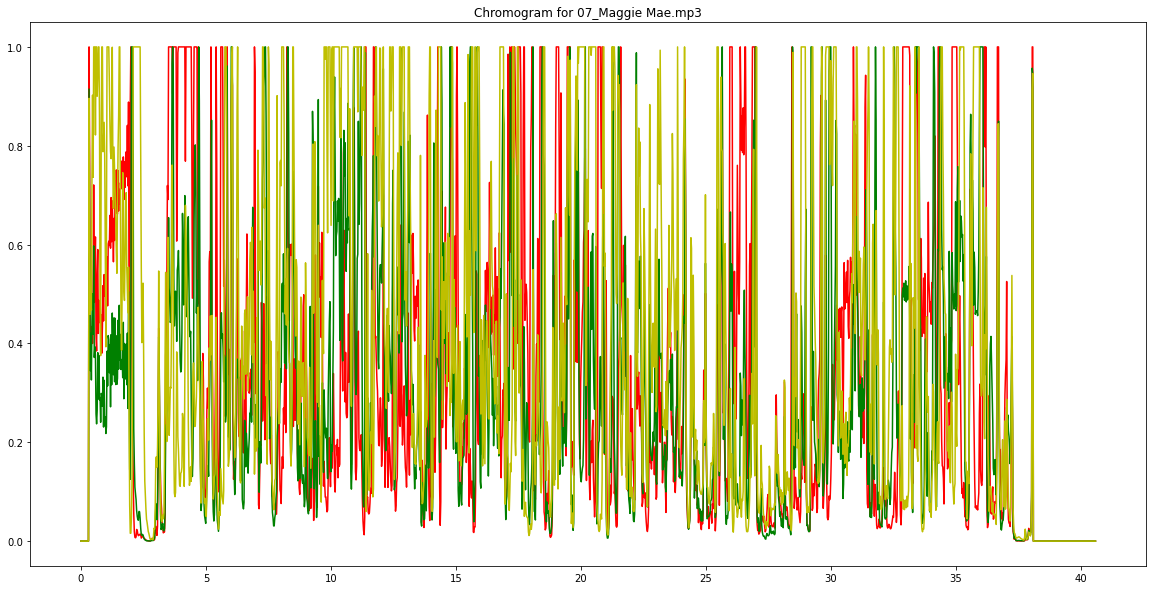

In [63]:
# Develop a chromagram of waveform - first 200 frames
chroma = librosa.feature.chroma_stft(sound)

# print(chroma.shape)
# graph first three

plt.figure(figsize=(20,10))

c_length = chroma.shape[1]
plt.plot(t, chroma[0].reshape(c_length,1), color='r')
plt.plot(t, chroma[1].reshape(c_length,1), color='g')
plt.plot(t, chroma[2].reshape(c_length,1), color='y')

plt.title('Chromogram for '+audio_file)
plt.show()


### Feature Selection

* The routines below read the music files, develop the features, and store them away in a csv file for later processing.

* Where features are vectors, we are capturing only the max, min, mean, standard deviation, kurtosis and skew of those vectors, rather than the full vectors themselves.

In [ ]:
# Full list of features for reference:

# centroid_max
# centroid_min
# centroid_mean
# centroid_std
# centroid_kurtosis
# centroid_skew

# rolloff_max
# rolloff_min
# rolloff_mean
# rolloff_std
# rolloff_kurtosis
# rolloff_skew

# flux_max
# flux_min
# flux_mean
# flux_std
# flux_kurtosis
# flux_skew

# rmse_max
# rmse_min
# rmse_mean
# rmse_std
# rmse_kurtosis
# rmse_skew

# zcr_max
# zcr_min
# zcr_mean
# zcr_std
# zcr_kurtosis
# zcr_skew

# contrast_max
# contrast_min
# contrast_mean
# contrast_std
# contrast_kurtosis
# contrast_skew

# bandwidth_max
# bandwidth_min
# bandwidth_mean
# bandwidth_std
# bandwidth_kurtosis
# bandwidth_skew

# flatness_max
# flatness_min
# flatness_mean
# flatness_std
# flatness_kurtosis
# flatness_skew

# chroma_stft_max
# chroma_stft_min
# chroma_stft_mean
# chroma_stft_std
# chroma_stft_kurtosis
# chroma_stft_skew

# mfcc_0_max
# mfcc_0_min
# mfcc_0_mean
# mfcc_0_std
# mfcc_0_kurtosis
# mfcc_0_skew
# mfcc_1_max
# mfcc_1_min
# mfcc_1_mean
# mfcc_1_std
# mfcc_1_kurtosis
# mfcc_1_skew
# mfcc_2_max
# mfcc_2_min
# mfcc_2_mean
# mfcc_2_std
# mfcc_2_kurtosis
# mfcc_2_skew
# mfcc_3_max
# mfcc_3_min
# mfcc_3_mean
# mfcc_3_std
# mfcc_3_kurtosis
# mfcc_3_skew
# mfcc_4_max
# mfcc_4_min
# mfcc_4_mean
# mfcc_4_std
# mfcc_4_kurtosis
# mfcc_4_skew
# mfcc_5_max
# mfcc_5_min
# mfcc_5_mean
# mfcc_5_std
# mfcc_5_kurtosis
# mfcc_5_skew
# mfcc_6_max
# mfcc_6_min
# mfcc_6_mean
# mfcc_6_std
# mfcc_6_kurtosis
# mfcc_6_skew
# mfcc_7_max
# mfcc_7_min
# mfcc_7_mean
# mfcc_7_std
# mfcc_7_kurtosis
# mfcc_7_skew
# mfcc_8_max
# mfcc_8_min
# mfcc_8_mean
# mfcc_8_std
# mfcc_8_kurtosis
# mfcc_8_skew
# mfcc_9_max
# mfcc_9_min
# mfcc_9_mean
# mfcc_9_std
# mfcc_9_kurtosis
# mfcc_9_skew
# mfcc_10_max
# mfcc_10_min
# mfcc_10_mean
# mfcc_10_std
# mfcc_10_kurtosis
# mfcc_10_skew
# mfcc_11_max
# mfcc_11_min
# mfcc_11_mean
# mfcc_11_std
# mfcc_11_kurtosis
# mfcc_11_skew
# mfcc_12_max
# mfcc_12_min
# mfcc_12_mean
# mfcc_12_std
# mfcc_12_kurtosis
# mfcc_12_skew

# total_frames
# silent_frames
# tempo


In [6]:
# Get various moments from the vectors
def get_moments(descriptors):
    result = {}
    for k, v in descriptors.items():
        result['{}_max'.format(k)] = np.max(v)
        result['{}_min'.format(k)] = np.min(v)
        result['{}_mean'.format(k)] = np.mean(v)
        result['{}_std'.format(k)] = np.std(v)
        result['{}_kurtosis'.format(k)] = kurtosis(v)
        result['{}_skew'.format(k)] = skew(v)
    return result


In [7]:
def get_features(wave, sr):                            # Collect features from a waveform
    
    features = {
                'centroid': None,                      # start with only vector features for which we need moments
                'rolloff': None, 
                'flux': None, 
                'rmse': None,
                'zcr': None, 
                'contrast': None, 
                'bandwidth': None, 
                'flatness': None, 
                'chroma_stft': None
               }

# Built-in librosa functions
    features['centroid'] = librosa.feature.spectral_centroid(wave, sr=sr).ravel()
    features['rolloff'] = librosa.feature.spectral_rolloff(wave, sr=sr,).ravel()
    features['flux'] = librosa.onset.onset_strength(y=wave, sr=sr).ravel()
    features['rmse'] = librosa.feature.rms(wave).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(wave).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(wave, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(wave, sr=sr).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(wave).ravel()
    features['chroma_stft']=librosa.feature.chroma_stft(y=wave, sr=sr).ravel()
    
# special MFCC treatment
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
   
    dict_agg_features = get_moments(features)
    
# Now add non-vector features
    dict_agg_features['total_frames'] = len(wave)
    
    audible, _ = librosa.effects.trim(wave)
    dict_agg_features['silent_frames'] = len(wave) - len(audible)  
    
    dict_agg_features['tempo'] = librosa.beat.beat_track(wave, sr=sr)[0]   # beats per minute
    
    return dict_agg_features

In [53]:
# Process single file for testing and tuck features into a CSV

feature_repo = []                                                 # Drop all features into big array

print('Processing:', audio_file,'...', end = '')

with warnings.catch_warnings():                                   # Avoid warning about reading MP3s
    warnings.simplefilter("ignore")
    sound, sr = librosa.load(audio_file)

features = get_features(sound,sr)
features["filename"] = audio_file                                 # Include filename for reference

feature_repo.append(features)                                     # Collect each set
print("Done.")


pd.DataFrame(feature_repo).to_csv('single.csv', index=False)    # Write out to file   

print('single.csv is ready.')


Processing: 07_Maggie Mae.mp3 ...Done.
single.csv is ready.


In [136]:
# Process complete library and tuck features into a CSV

top_level = 'beatles_library'     

feature_repo = []                                                 # Drop all features into big array

for subdir, dirs, files in os.walk(top_level):                    # Note, no order guaranteed here!! Worth sorting?
    for file in files:
        if file.endswith(".mp3"):                                 # Skip jpegs, etc.
            full_path = os.path.join(subdir, file)
            print('Processing:', full_path,'...', end = '')

            with warnings.catch_warnings():                       # Avoid warning about reading MP3s
                warnings.simplefilter("ignore")
                sound, sr = librosa.load(full_path)

            features = get_features(sound,sr)
            
            features["filename"] = full_path                      # Include filename for reference

            feature_repo.append(features)                         # Add another row of features
            print("Done.")

pd.DataFrame(feature_repo).to_csv('features.csv', index=False)    # Write out to file            
print('features.csv is now ready.')

Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/02_Something.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/01_Come Together.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/14_Golden Slumbers.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/09_You Never Give Me Your Money.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/13_She Came in Through the Bathroom Window.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/07_Here Comes the Sun.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/12_Polythene Pam.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/16_The End.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/15_Carry That Weight.mp3 ...Done.
Processing: beatles_library/1969-09 Abbey Road (2009 Remaster)/06_I Want You (She's So Heavy).mp3 ...Done.
Processing: be

Processing: beatles_library/1963-11 With the Beatles/10_You've Really Got a Hold on Me.mp3 ...Done.
Processing: beatles_library/1963-11 With the Beatles/04_Don't Bother Me.mp3 ...Done.
Processing: beatles_library/1963-11 With the Beatles/13_Not a Second Time.mp3 ...Done.
Processing: beatles_library/1963-11 With the Beatles/12_Devil in Her Heart.mp3 ...Done.
Processing: beatles_library/1963-11 With the Beatles/06_Till There Was You.mp3 ...Done.
Processing: beatles_library/1963-11 With the Beatles/05_Little Child.mp3 ...Done.
Processing: beatles_library/1963-11 With the Beatles/03_All My Loving.mp3 ...Done.
Processing: beatles_library/1963-11 With the Beatles/02_All I've Got to Do.mp3 ...Done.
Processing: beatles_library/1963-03 Please Please Me/11_Do You Want to Know a Secret.mp3 ...Done.
Processing: beatles_library/1963-03 Please Please Me/06_Ask Me Why.mp3 ...Done.
Processing: beatles_library/1963-03 Please Please Me/01_I Saw Her Standing There.mp3 ...Done.
Processing: beatles_library

## Clustering analysis

I took the following steps to try to find an appropriate method for grouping the tracks into "moods:"

* I standardized the features and then reduced the number of features using PCA.  Using the first 20 principal components appeared to capture about 75% of the variance; additional components did not appear to add much information. Performance using first 20 was acceptable on this dataset.
* I then processed the data using three techniques:
    * K-means, for a variety of different values of k
    * Spectral clustering
    * Agglomerative clustering, with a variety of hyperparameters


## Clustering analysis (continued)

* I evaluated the clustering using 3 different numerical measures:
    * Silhouette score (explained in our Thinkful lessons) - range from -1 (bad) to 1 (good)
    * Calinski-Harabasz - ratio between the within-cluster dispersion and the between-cluster dispersion (low is "better")
    * Davies-Bouldin - average similarity measure (ratio of within-cluster distances to between-cluster distances) of each cluster with its most similar cluster (low is "better")
* I also examined plots of the clustering, using the first 2 principal components and the clusters represented by color.

In [3]:
# Read in the features

df = pd.read_csv("features.csv")
df.head(3)

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,rolloff_max,rolloff_min,rolloff_mean,rolloff_std,...,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,total_frames,silent_frames,tempo,filename
0,5747.412380,391.150971,1782.795875,712.333933,2.756261,1.274198,8979.345703,344.531250,3767.199740,1616.611110,...,20.753494,-35.379395,-4.958991,7.513413,0.143944,0.032788,4019568,63856,135.999178,beatles_library/1969-09 Abbey Road (2009 Remas...
1,5949.771376,0.000000,2015.854977,964.758951,-0.010778,0.482555,9259.277344,0.000000,4299.589198,2011.397363,...,39.275284,-33.387062,-0.898577,8.319617,0.905401,0.343944,5731824,105968,172.265625,beatles_library/1969-09 Abbey Road (2009 Remas...
2,5371.934240,464.559517,1297.719245,628.635054,6.781371,2.063880,9388.476562,656.762695,2583.774601,1328.775420,...,25.355783,-30.937057,-0.391158,7.600591,0.246185,-0.167040,2023308,7168,80.749512,beatles_library/1969-09 Abbey Road (2009 Remas...


In [4]:
# Strip out filename and scale the features

X = df.drop(['filename'], axis=1)  # Not a feature, just a label
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
display(X_scaled.head(5))

# Keep filenames separately for storing cluster info later
files = df[['filename']].squeeze()  # make it a series
display(files.head(5))


,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,rolloff_max,rolloff_min,rolloff_mean,rolloff_std,...,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,total_frames,silent_frames,tempo
0,-0.418833,0.531647,-1.017695,0.100869,-0.453929,0.710294,-0.664039,0.073148,-0.789087,0.600571,...,-0.609613,-0.507871,-0.509494,0.134250,0.275597,-0.350714,-0.271517,-0.083743,-0.200232,0.428867
1,-0.292156,-0.672295,-0.449492,2.111947,-1.221627,0.009600,-0.244913,-0.541688,-0.177341,2.037553,...,-0.629357,2.106641,-0.160111,1.500595,1.106897,1.261325,1.319992,0.161410,0.688465,1.860058
2,-0.653883,0.757595,-2.200322,-0.565963,0.662814,1.409251,-0.051470,0.630344,-2.148909,-0.447122,...,-1.300135,0.141783,0.269532,1.671343,0.365488,-0.134266,-1.293596,-0.369559,-1.396528,-1.751462
3,-0.067587,0.470134,-1.013049,-0.085061,-0.732230,0.199180,-1.276608,0.073148,-1.114416,0.235362,...,0.304585,0.653303,-0.534906,-0.388105,0.623713,-0.239300,1.087516,0.107825,-1.396528,1.860058
4,-0.804663,1.471947,0.416414,0.326143,-1.105235,0.086218,-1.260488,1.418103,0.663950,-0.008448,...,-0.600279,0.255428,1.320983,1.320626,-0.530917,1.488036,1.654224,-0.284740,-0.782553,1.435173


0    beatles_library/1969-09 Abbey Road (2009 Remas...
1    beatles_library/1969-09 Abbey Road (2009 Remas...
2    beatles_library/1969-09 Abbey Road (2009 Remas...
3    beatles_library/1969-09 Abbey Road (2009 Remas...
4    beatles_library/1969-09 Abbey Road (2009 Remas...
Name: filename, dtype: object

In [5]:
# Run features through PCA

pca = PCA(n_components=20,
          whiten=False)
pca.fit(X_scaled)

PCA(n_components=20)

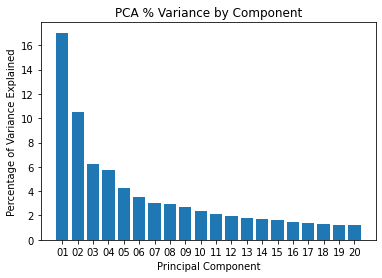

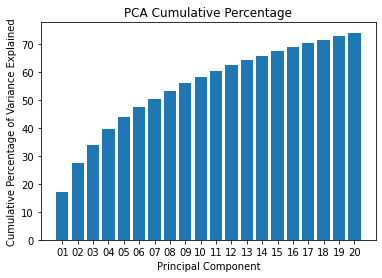

In [6]:
# Look at % variance explained

percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = np.array(['01', 
                    '02', 
                    '03', 
                    '04', 
                    '05', 
                    '06', 
                    '07', 
                    '08', 
                    '09', 
                    '10', 
                    '11',
                    '12',
                    '13',
                    '14',
                    '15',
                    '16',
                    '17',
                    '18',
                    '19',
                    '20',
                   ])
plt.figure(1)
plt.bar(columns[:pca.n_components], np.array(percent_variance[:pca.n_components]))
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA % Variance by Component')
plt.show()

percent_cumulative_variance = np.cumsum(percent_variance)
plt.figure(2)
plt.bar(columns[:pca.n_components], np.array(percent_cumulative_variance[:pca.n_components]))
plt.ylabel('Cumulative Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Cumulative Percentage')
plt.show()

In [10]:
# go ahead and use 20 to get ~75% of variance - performance is still decent on this size dataset.
# 75% appears to be an asymptote, almost

xPCA = pca.transform(X_scaled)  


In [63]:
# Develop UMAP reduction of dataset for visualization only
# Suggested by Tiago

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_scaled)


,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2.0,0.134079,35.128039,2.215178
1,3.0,0.138615,31.819374,2.074872
2,4.0,0.144081,27.648844,2.146315
3,5.0,0.112472,24.520595,2.127144
4,6.0,0.124590,22.570614,1.963151


<function matplotlib.pyplot.show(close=None, block=None)>

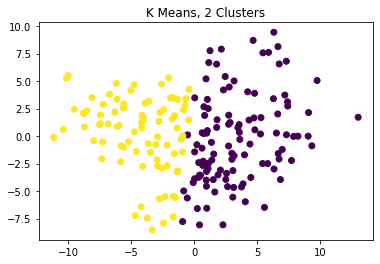

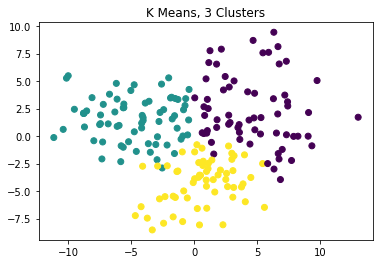

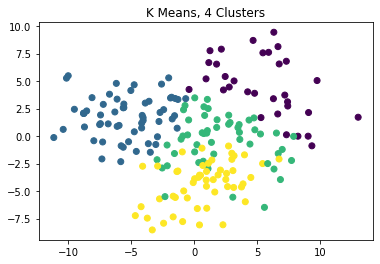

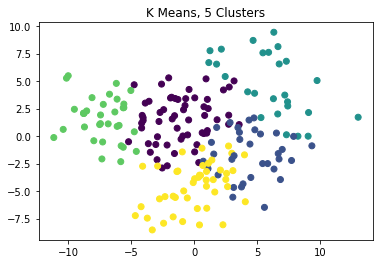

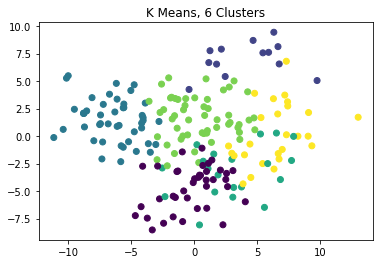

In [66]:
# Try kmeans clustering - visualize and compute scores

scores = pd.DataFrame(columns=['Clusters','Silhouette','Calinski-Harabasz','Davies-Bouldin'])

for clusters in range(2, 7):                                # 5 and beyond appears to get muddled; 4 has best silhouette

    x = xPCA
    kmeans = KMeans(n_clusters=clusters,random_state=13)
    kmeans.fit(x)

    plt.figure()
    plt.title('K Means, '+str(clusters)+' Clusters')
    plt.scatter(x[:,0], x[:,1], c=kmeans.labels_)
#    plt.scatter(umap_results[:,0], umap_results[:,1], c=kmeans.labels_)  # Tiago suggested this
    
    scores = scores.append({'Clusters':clusters,
                            'Silhouette':metrics.silhouette_score(x, kmeans.labels_, metric='euclidean'),
                            'Calinski-Harabasz':metrics.calinski_harabasz_score(x, kmeans.labels_),
                            'Davies-Bouldin':metrics.davies_bouldin_score(x, kmeans.labels_)
                           }, ignore_index=True)
    
display(scores)
plt.show


* With k-means, 5 or more clusters appears "muddled" - separation is poor.

* Four clusters appears best both in terms of silhouette score and the 2-component plot.

,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2.0,0.132462,28.695326,2.463080
1,3.0,0.133721,29.770010,2.166748
2,4.0,0.113228,25.325379,2.169756
3,5.0,0.110531,23.600554,2.108754


<function matplotlib.pyplot.show(close=None, block=None)>

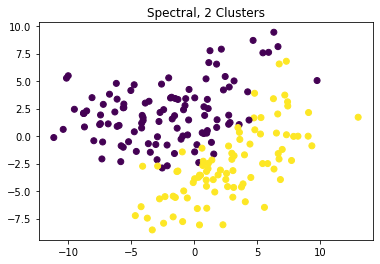

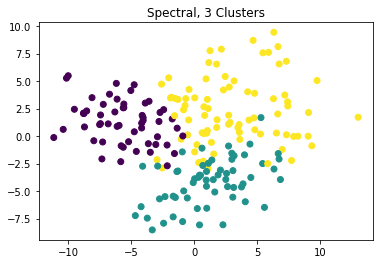

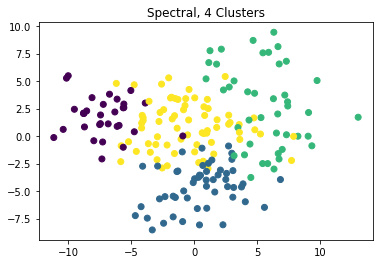

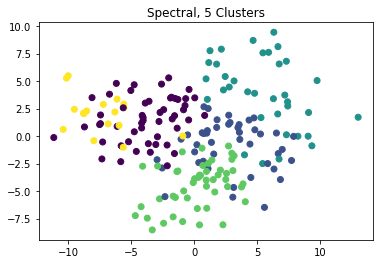

In [67]:
# Try spectral clustering - visualize & scores

scores = pd.DataFrame(columns=['Clusters','Silhouette','Calinski-Harabasz','Davies-Bouldin'])

for clusters in range(2, 6):                                # 4 and beyond appears to get muddled

    x = xPCA
    spec = SpectralClustering(n_clusters=clusters,
                              assign_labels="discretize",
                              random_state=13,
                              affinity="nearest_neighbors",
                              n_neighbors=20)
    spec.fit(x)

    plt.figure(clusters)
    plt.title('Spectral, '+str(clusters)+' Clusters')
    plt.scatter(x[:,0], x[:,1], c=spec.labels_)
#    plt.scatter(umap_results[:,0], umap_results[:,1], c=spec.labels_)  # Tiago suggested this

    scores = scores.append({'Clusters':clusters,
                            'Silhouette':metrics.silhouette_score(x, spec.labels_, metric='euclidean'),
                            'Calinski-Harabasz':metrics.calinski_harabasz_score(x, spec.labels_),
                            'Davies-Bouldin':metrics.davies_bouldin_score(x, spec.labels_)
                           }, ignore_index=True)
    
display(scores)
    
plt.show


* With spectral clustering, separation does not appear to be as good as with k-means clustering.

* Beyond 3 clusters, silhouette scores drop and the plots appear "muddled."

,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2.0,0.110835,28.699138,2.150892
1,3.0,0.121426,26.982163,2.244045
2,4.0,0.119525,24.582116,2.228656
3,5.0,0.123295,21.795988,1.935119
4,6.0,0.110972,19.860129,1.896146
5,7.0,0.117746,18.631886,1.814171
6,8.0,0.099764,17.686680,1.908606
7,9.0,0.096407,16.995650,1.962601


<function matplotlib.pyplot.show(close=None, block=None)>

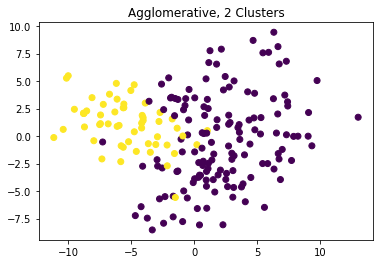

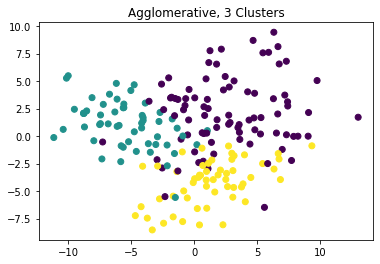

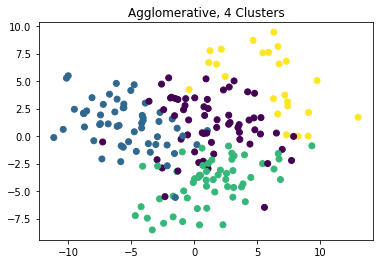

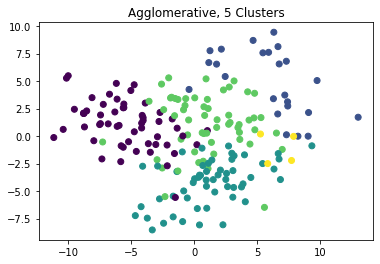

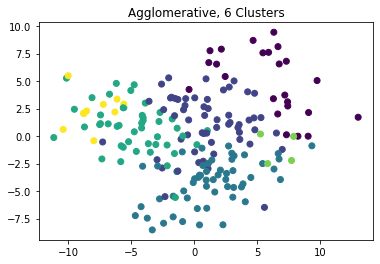

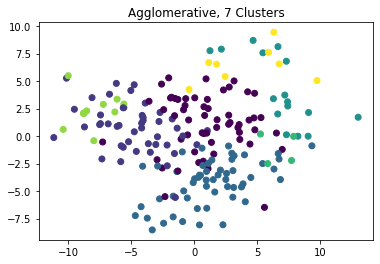

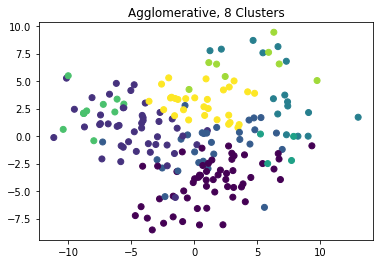

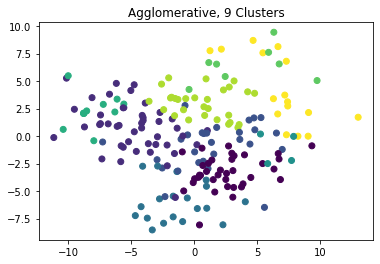

In [68]:
# Try agglomerative clustering

scores = pd.DataFrame(columns=['Clusters','Silhouette','Calinski-Harabasz','Davies-Bouldin'])

for clusters in range(2, 10):                                # This is *maximum*, not specified, clusters
                                                             
    x = xPCA
    ac = AgglomerativeClustering(n_clusters = clusters,
                                 linkage="ward",              # Similar size linkage - may be inappropriate?
#                                  linkage="complete",         # No clear clustering, terrible silhouette after 2 clusters
#                                 linkage="average",           # Great silhouette at 2 clusters but looks muddled
                                 affinity="euclidean",        # Terrible results with average linkage
#                                 affinity="cosine"            # Okay with average linkage up to 3 clusters
                                )
    ac.fit(x)
    
    plt.figure(clusters)
    plt.title('Agglomerative, '+str(clusters)+' Clusters')
    plt.scatter(x[:,0], x[:,1], c=ac.labels_)
#    plt.scatter(umap_results[:,0], umap_results[:,1], c=ac.labels_)  # Tiago suggested this
    
    scores = scores.append({'Clusters':clusters,
                            'Silhouette':metrics.silhouette_score(x, ac.labels_, metric='euclidean'),
                            'Calinski-Harabasz':metrics.calinski_harabasz_score(x, ac.labels_),
                            'Davies-Bouldin':metrics.davies_bouldin_score(x, ac.labels_)
                           }, ignore_index=True)
    
display(scores)
    
plt.show


Agglomerative clustering appears to be quite sensitive to hyperparameters chosen, e.g.
* Ward linkage (which needs eucliden distance measure) is okay at 3 or 4 clusters.  Ward finds clusters of similar size, which in this case may not be appropriate (no reason to think "mood" evenly distributed across dataset).
* Average linkage yields acceptable results with cosine measure (up to 3 clusters, however), terrible results with euclidean.
* Slowest of the three algorithms here, so may not scale well to bigger music library.

### Summary

* Of the approaches examined, K-Means with 4 clusters appears the best, both in terms of silhouette score and visual plotting.  Four clusters is fewer than I believe appropriate for the range of "moods," but we'll take that for now.

* Now, time to assign the cluster identifier back to specific tracks and review the results.

In [1]:
# Using K-means with 4 clusters, place the cluster label back alongside the filename.

x = xPCA
kmeans = KMeans(n_clusters=4,random_state=13)
kmeans.fit(x)

cluster_labels = pd.Series(kmeans.labels_, name='Cluster')
#display(cluster_labels.hvplot.table())

# Line up cluster numbers with filenames and then browse to see if the clustering makes sense
results = pd.concat([files, cluster_labels], axis=1, ignore_index=True)

display(results.hvplot.table())

#results.to_csv('results.csv', index=False)    # Write out to file    

NameError: name 'xPCA' is not defined

### Summary and Next Steps

* Analyzing the clustering (K-means, 4 clusters), I can find some general patterns, but I do not think it sufficiently identifies "mood" in a way that would be satisfactory for playlist development (see CSV in Excel for examples).
* At this stage, I don't have a sense of which features are driving the clustering and which features may be of little or no use.


### Summary and Next Steps (cont.)

* I may need to assign moods on a set of tracks and use supervised learning to find out which features are of most importance.  Then, I can use more weight on the more-important features (as opposed to just standardizing all of the features) and see if clustering is more successful.
* I may also need to consider whether I need some way to assign tracks to multiple clusters (with or without some kind of "primary" or "secondary" measure).  This might better reflect the mood concept in practice, although it could also make analysis even more complex.


### Summary and Next Steps (cont.)

* Once I have a good algorithm, I would like to apply it to my entire library.  That would require some further changes in my code and some additional steps:
    * I will likely need to make use of parallel processing so I can develop features on multiple tracks simultaneously.  Right now I am doing it sequentially; it takes about 45 minutes on my machine to extract features just for the Beatles tracks.
    * Once I have the appropriate cluster labels, I would like to place those back into the .MP3 files themselves (as tags), so that they are readily available to my music players and any playlist programs I may use.